# U-net test with the Planetscope data and a OSM "ground truth" mask

In [1]:
## Import libraries
# system
import os
from collections import defaultdict
import time
import copy
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from functools import reduce

### Convolutional Neural Networks
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import random_split
from torchsummary import summary


# data manipulation
import random
import numpy as np
from PIL import Image
from io import BytesIO
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr

# visualization
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm


repo_name = 'masterthesis_genai_spatialplan'
if not repo_name in os.getcwd():
    os.chdir(repo_name)

p=os.popen('git rev-parse --show-toplevel')
repo_dir = p.read().strip()
p.close()

#seaborn cmap
rocket=sns.color_palette("rocket", as_cmap=True)
mako=sns.color_palette("mako", as_cmap=True)

### Load and explore the data

In [3]:
# input_xs=xr.open_zarr(
#     f"{repo_dir}/data/model_input_dataset.zarr",
#     consolidated=True,
# )
input_xs=xr.open_zarr(
    f"/work/zt75vipu-genai_spatial/model_input_dataset.zarr",
    consolidated=True,
)
input_xs = input_xs[['buildings', 'planetscope_sr_4band']].isel(time=1)
input_xs['buildings'] = input_xs['buildings'].fillna(0)
input_xs

/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.Dataset> Size: 375MB
Dimensions:               (y: 5635, x: 5544, channel: 4)
Coordinates:
  * channel               (channel) object 32B 'blue' 'green' 'red' 'nir'
    time                  datetime64[ns] 8B 2019-06-24
  * x                     (x) float64 44kB 3.097e+05 3.097e+05 ... 3.263e+05
    spatial_ref           int64 8B ...
  * y                     (y) float64 45kB 5.7e+06 5.7e+06 ... 5.683e+06
Data variables:
    buildings             (y, x) float32 125MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    planetscope_sr_4band  (channel, y, x) int16 250MB dask.array<chunksize=(4, 1024, 1024), meta=np.ndarray>

In [4]:
class PatchDataset(Dataset):
    def __init__(self, input_xs, patch_size=192, stride=192, transform=None):
        
        self.img = input_xs['planetscope_sr_4band'].sel(channel=['blue', 'green', 'red']).values
        self.mask = input_xs['buildings'].values
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        # calc patch indices
        self.patches = []
        H, W = self.mask.shape
        for y in range(0, H - patch_size + 1, stride):
            for x in range(0, W - patch_size + 1, stride):
                self.patches.append((y, x))

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        y, x = self.patches[idx]
        img_patch = self.img[:, y:y+self.patch_size, x:x+self.patch_size].astype(np.float32)
        mask_patch = self.mask[y:y+self.patch_size, x:x+self.patch_size].astype(np.float32)
        
        # normalize to [0,1]
        img_patch = (img_patch - img_patch.min()) / (img_patch.max() - img_patch.min() + 1e-6)
        
        # add channel dim to mask if needed
        mask_patch = np.expand_dims(mask_patch, axis=0)
        if self.transform:
            img_patch = self.transform(img_patch)
            mask_patch = self.transform(mask_patch)
        else:
            img_patch = torch.from_numpy(img_patch)
            mask_patch = torch.from_numpy(mask_patch)
        return img_patch, mask_patch

resolution = 3 # resolution in meters
pixel_size = 500 # pixel size in meters
image_size = int(500/3)
# find image size as multiple of 16
if image_size % 16 != 0:
    image_size = int(image_size / 16) * 16
    print(f"Image size adjusted to {image_size} to be a multiple of 16")

# example
patch_dataset = PatchDataset(input_xs, patch_size=image_size, stride=image_size)
patch_loader = DataLoader(patch_dataset, batch_size=8, shuffle=True)

inputs, masks = next(iter(patch_loader)) # get the first batch
print(inputs.shape, masks.shape)

Image size adjusted to 160 to be a multiple of 16
torch.Size([8, 3, 160, 160]) torch.Size([8, 1, 160, 160])


plot example mask and image

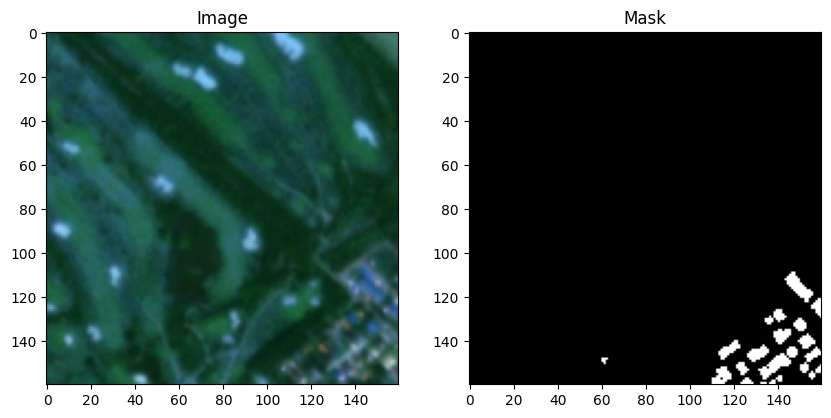

In [5]:
# plot example mask and image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(inputs[0].permute(1, 2, 0).numpy())
ax[0].set_title('Image')
ax[1].imshow(masks[0].squeeze().numpy(), cmap='gray')
ax[1].set_title('Mask')
plt.show()

In [6]:
# transform func for data augmentation in future
trans = None 
# trans = transforms.Compose([
#     transforms.ToTensor(),
# ])

# create full dataset
patch_dataset = PatchDataset(input_xs, patch_size=image_size, stride=image_size, transform=trans)

# split into 80% train, 20% val
train_size = int(0.8 * len(patch_dataset))
val_size = len(patch_dataset) - train_size
train_set, val_set = random_split(patch_dataset, [train_size, val_size])

batch_size = 8

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
}

dataset_sizes = {
    'train': len(train_set),
    'val': len(val_set)
}

Create U-net functions (borrowed from https://github.com/usuyama/pytorch-unet/tree/master)

In [7]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class ConditionalUNet(nn.Module):
    def __init__(self, output_channels=3):
        super().__init__()
        
        # Input: 3 RGB channels + 1 mask channel = 4 input channels
        self.dconv_down1 = double_conv(4, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        # output RGB image
        self.conv_last = nn.Conv2d(64, output_channels, 1)
        
    def forward(self, x, mask):
        # concatenate image and mask along channel dimension
        x = torch.cat([x, mask], dim=1)  # [batch, 4, H, W]
        
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

torch.Size([8, 3, 160, 160]) torch.Size([8, 1, 160, 160])
0.0 1.0 0.22735286 0.19784057
0.0 1.0 0.08904785 0.2848128


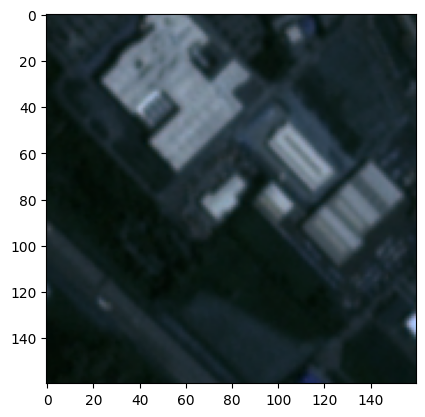

In [8]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

Check resolution against the original data

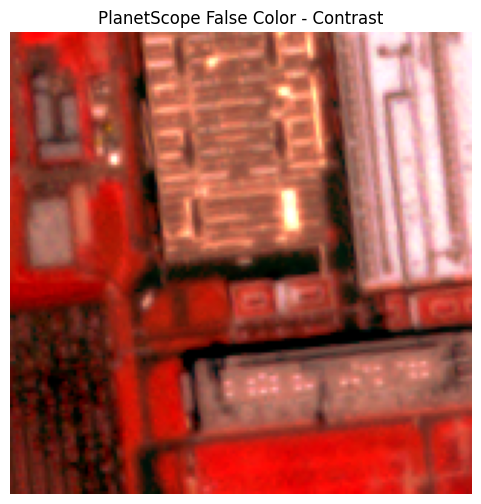

In [9]:
x = 400
reflectance = input_xs.planetscope_sr_4band[0:4,x:x+160,x:x+160]
#false color composite
rgb = np.stack([reflectance.sel(channel="nir"), reflectance.sel(channel="red"), reflectance.sel(channel="green")], axis=-1)

# Percentile-based contrast stretch
p_low, p_high = 2, 98
rgb_min = np.nanpercentile(rgb, p_low)
rgb_max = np.nanpercentile(rgb, p_high)
rgb_stretched = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)

plt.figure(figsize=(6, 6))
plt.imshow(rgb_stretched)
plt.title("PlanetScope False Color - Contrast")
plt.axis('off')
plt.show()

Print model summary

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# num_class = 1 # how many classes in segementation (e.g., building, road, vegetation, water, etc.) --> for now only buildings
model = ConditionalUNet(output_channels=3).to(device)

print ("device: ", device)
summary(model, [(3, 224, 224), (1, 224, 224)])

device:  cuda
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 224, 224]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        2,368
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
├─MaxPool2d: 1-2                         [-1, 64, 112, 112]        --
├─Sequential: 1-3                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-5                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-6                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-7                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-8                         [-1, 128, 112, 112]       --
├─MaxPool2d: 1-4                         [-1, 128, 56, 56]         --
├─Sequential: 1-5                        [-1, 256, 56, 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 224, 224]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        2,368
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
├─MaxPool2d: 1-2                         [-1, 64, 112, 112]        --
├─Sequential: 1-3                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-5                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-6                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-7                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-8                         [-1, 128, 112, 112]       --
├─MaxPool2d: 1-4                         [-1, 128, 56, 56]         --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --

Create loss and training functions

In [17]:
# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)
        
#     pred = F.sigmoid(pred)
#     dice = dice_loss(pred, target)
    
#     loss = bce * bce_weight + dice * (1 - bce_weight)
    
#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
#     return loss

def calc_image_loss(pred_img, target_img, metrics, l1_weight=0.7, l2_weight=0.3):
    # L1 loss (MAE) - good for sharp details
    l1_loss = F.l1_loss(pred_img, target_img)
    
    # L2 loss (MSE) - good for overall reconstruction
    l2_loss = F.mse_loss(pred_img, target_img)
    
    # combined loss
    total_loss = l1_loss * l1_weight + l2_loss * l2_weight
    
    metrics['l1_loss'] += l1_loss.data.cpu().numpy() * target_img.size(0)
    metrics['l2_loss'] += l2_loss.data.cpu().numpy() * target_img.size(0)
    metrics['loss'] += total_loss.data.cpu().numpy() * target_img.size(0)
    
    return total_loss



def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_conditional_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    # each epoch has a training and validation phase
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                model.train()
            else:
                model.eval()

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # use mask as condition to generate image
                    pred_img = model(inputs, masks)
                    loss = calc_image_loss(pred_img, inputs, metrics)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Train the model

In [18]:
# adam optimizer to optimize all parameters
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4) 

# learning rate scheduler to reduce the learning rate by a factor gamma every step_size epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

# train the model num_epochs times on the training set
model = train_conditional_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------
LR 0.0001


/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train: l1_loss: 0.054795, l2_loss: 0.008494, loss: 0.040905
val: l1_loss: 0.024861, l2_loss: 0.001691, loss: 0.017910
saving best model
0m 5s
Epoch 1/39
----------
LR 0.0001
train: l1_loss: 0.018767, l2_loss: 0.001007, loss: 0.013439
val: l1_loss: 0.014972, l2_loss: 0.000723, loss: 0.010697
saving best model
0m 5s
Epoch 2/39
----------
LR 0.0001
train: l1_loss: 0.012403, l2_loss: 0.000423, loss: 0.008809
val: l1_loss: 0.010123, l2_loss: 0.000292, loss: 0.007174
saving best model
0m 5s
Epoch 3/39
----------
LR 0.0001
train: l1_loss: 0.009479, l2_loss: 0.000231, loss: 0.006705
val: l1_loss: 0.008353, l2_loss: 0.000195, loss: 0.005905
saving best model
0m 5s
Epoch 4/39
----------
LR 0.0001
train: l1_loss: 0.008396, l2_loss: 0.000179, loss: 0.005931
val: l1_loss: 0.007625, l2_loss: 0.000160, loss: 0.005386
saving best model
0m 5s
Epoch 5/39
----------
LR 0.0001
train: l1_loss: 0.007584, l2_loss: 0.000148, loss: 0.005353
val: l1_loss: 0.007015, l2_loss: 0.000139, loss: 0.004952
saving best 

create a prediction and plot function

In [19]:
def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol
    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))
    for j in range(len(img_array)):
        plots[j // ncol, j % ncol].imshow(img_array[j])

def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x, y: x + y, zip(*img_arrays))
    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

def mask_to_colorimg(mask):
    colorimg = np.stack([mask[0]*255]*3, axis=-1).astype(np.uint8)
    return colorimg

def plot_prediction_batch(model, test_dataset, batch_size=3, batch_idx=0, device='cpu'):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    for i, (inputs, masks) in enumerate(test_loader):
        if i == batch_idx:
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            with torch.no_grad():
                pred_img = model(inputs, masks)

            # Convert to numpy for visualization
            pred_img_np = pred_img.data.cpu().numpy()
            masks_np = masks.data.cpu().numpy()
            
            # Prepare images for plotting
            input_images = [reverse_transform(x) for x in inputs.cpu()]
            pred_images = [reverse_transform(x) for x in pred_img.cpu()]
            mask_images = [mask_to_colorimg(x) for x in masks_np]
            
            # Plot: Original Image, Building Mask, Generated Image
            plot_side_by_side([input_images, mask_images, pred_images])
            break

Plot predictions

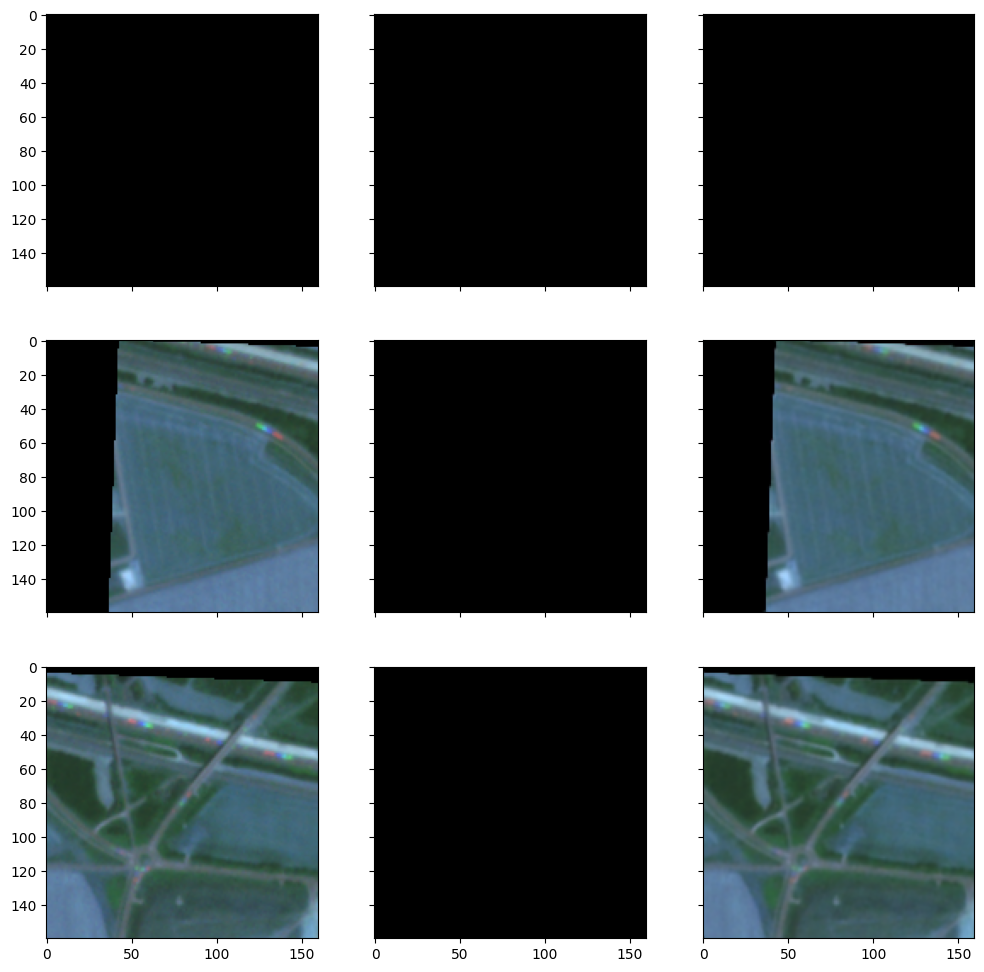

In [20]:
plot_prediction_batch(model, patch_dataset, batch_size=3, device=device)

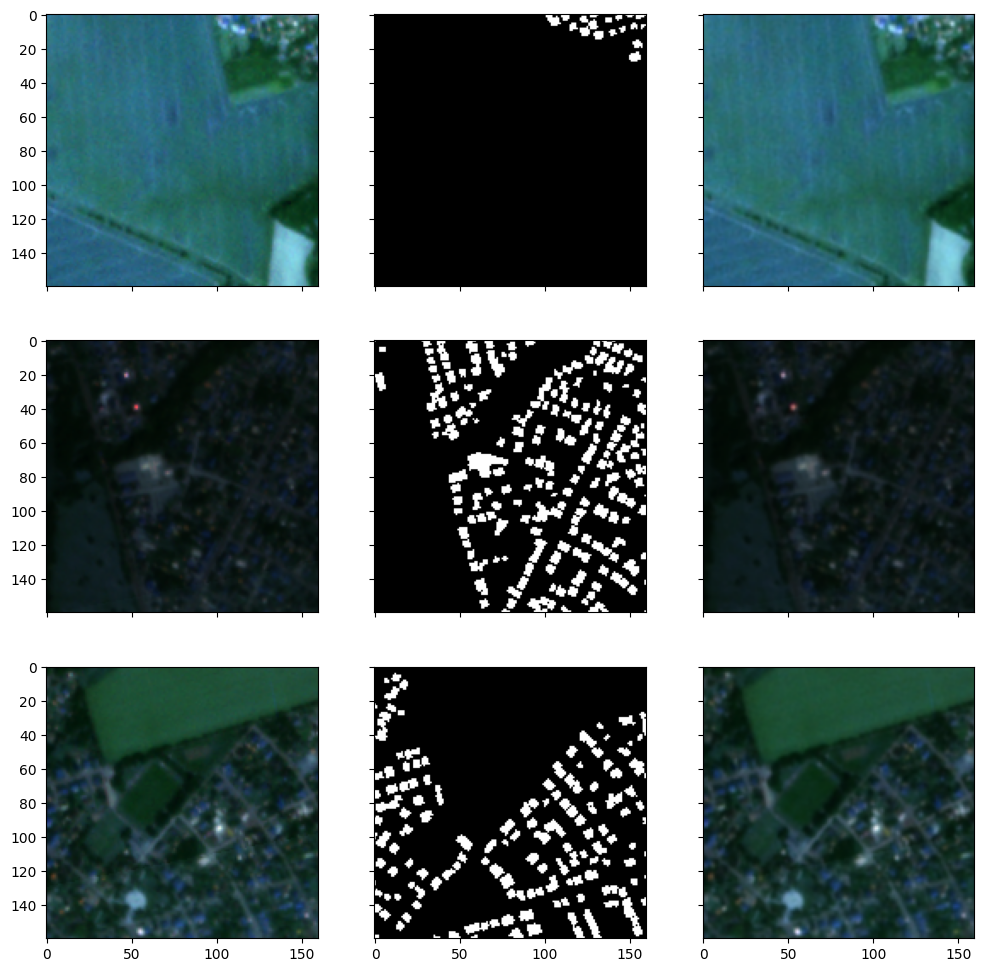

In [21]:
plot_prediction_batch(model, patch_dataset, batch_size=3, batch_idx=50, device=device)